In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from statsmodels.stats.proportion import proportion_confint
import seaborn as sns
sns.set_style("white")
%matplotlib inline

In [2]:
def listdir(path):
    ls = os.listdir(path)
    return [os.path.join(path, f) for f in ls]

def read_csv(fpath):
    df = pd.read_csv(fpath)#, index_col=[0])
    df['suite'] = fpath
    return df

def combine_data(path):
    dfs = list(map(read_csv, listdir(path)))
    data = pd.concat(dfs)
    data.drop('Unnamed: 0', inplace=True, axis=1)
    return data

def get_results(path):
    data = combine_data(path)
    solved = data[data.solved == True]
    print(f"{len(solved)} solved out of {len(data)} = {np.average(data.solved)*100:.1f}%")
    print(f"Avg solve in {solved.time.mean():.1f} sec")
    print("Solved vs. ShootMe/Klondike-Solver")
    print(pd.DataFrame(solved.shootme.value_counts()))
    
    fig, ax = plt.subplots(1, 2, figsize=(9,3))
    solved.visited.hist(ax=ax[0], bins=20)
    ax[0].set_title('Histogram of visited states')
    solved.time.hist(ax=ax[1], bins=20)
    ax[1].set_title('Histogram of time to solve');
    return data

781 solved out of 10000 = 7.8%
Avg solve in 0.0 sec
Solved vs. ShootMe/Klondike-Solver
            shootme
Solved-Min      760
Solved           21


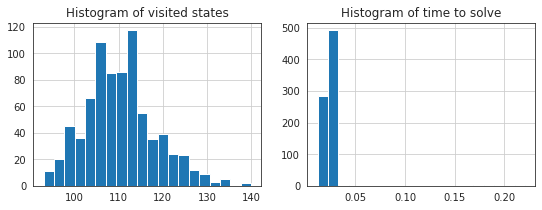

In [3]:
df_greedy = get_results('./bench/suite-10-greedyheuristic/')

3817 solved out of 10000 = 38.2%
Avg solve in 0.6 sec
Solved vs. ShootMe/Klondike-Solver
            shootme
Solved-Min     3701
Solved          114
Unknown           2


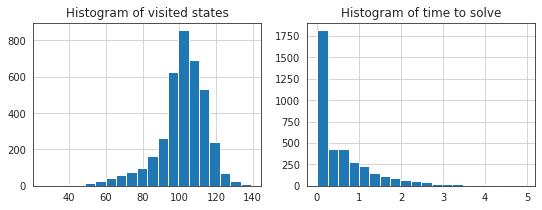

In [4]:
df_r1 = get_results("./bench/suite-10-rollout-0bb577bfe4/")

4175 solved out of 10000 = 41.8%
Avg solve in 5.1 sec
Solved vs. ShootMe/Klondike-Solver
            shootme
Solved-Min     4047
Solved          126
Unknown           2


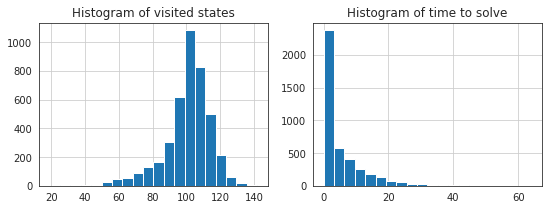

In [5]:
df_r2 = get_results("./bench/suite-10-rollout-k2-bf6bdd6e93")

4982 solved out of 10000 = 49.8%
Avg solve in 27.8 sec
Solved vs. ShootMe/Klondike-Solver
            shootme
Solved-Min     4827
Solved          152
Unknown           3


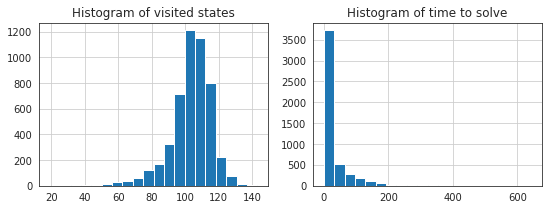

In [6]:
df_r3 = get_results("./bench/suite-10-rollout-k3-014d25000e")

3627 solved out of 6770 = 53.6%
Avg solve in 216.5 sec
Solved vs. ShootMe/Klondike-Solver
            shootme
Solved-Min     3512
Solved          112
Unknown           3


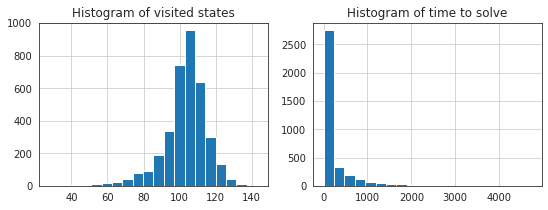

In [7]:
df_r4 = get_results("./bench/suite-10-rollout-k4-014d25000e") # in progress

58 solved out of 100 = 58.0%
Avg solve in 3.8 sec
Solved vs. ShootMe/Klondike-Solver
            shootme
Solved-Min       58


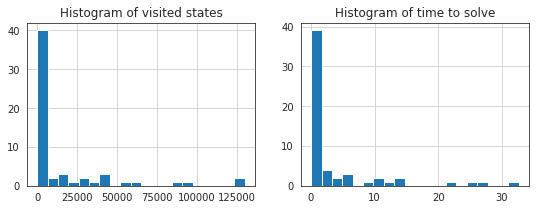

In [8]:
df_back = get_results('./bench/suite-10-backtracking/')

# Work on main figure draft

- Plot percentage solved for each strategy with confidence bound error bars
- Plot avg solve time per strategy
- Make dummy data for the ML strategy which isnt done yet (label as such)
- Comparing vs ShootMe -- how many unknown/impossibles were solved?

## Plotting win probabilities
With 99% CI error bars

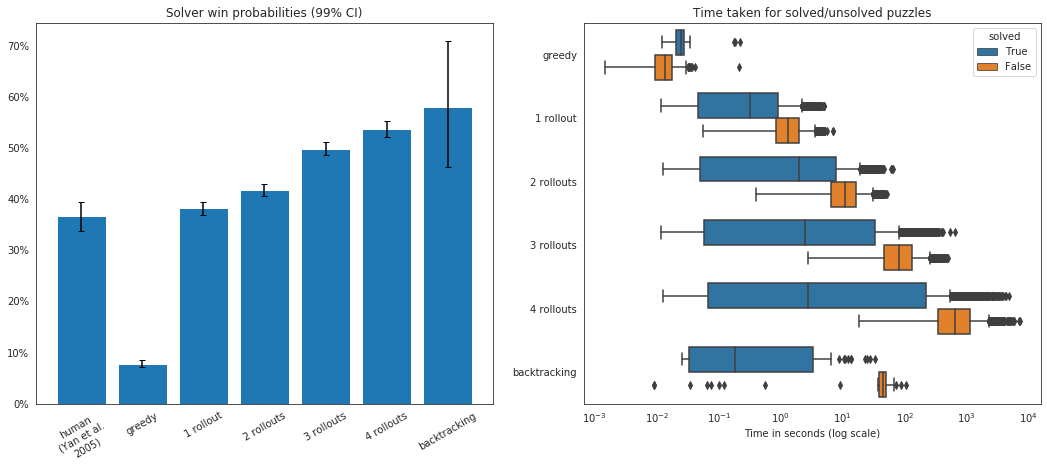

In [18]:
def fake(mu_solve=0.5, err_solve=0.1, solve_time=3.0):
    N = int(10/err_solve)
    return pd.DataFrame({   
        "solved": np.random.binomial(size=N, n=1, p=mu_solve).astype(bool),
        "time": np.random.normal(size=N, loc=solve_time),
    })

def mean(df):
    return np.mean(df.solved)

def confint(df):
    count = df.solved.value_counts()[True]
    nobs = df.solved.count()
    mu = mean(df)
    lo, hi = proportion_confint(count, nobs, alpha=0.01, method='wilson')
    return (lo-mu, mu-hi)
    

fig, axes = plt.subplots(1, 2, figsize=(18,7))
fig.patch.set_facecolor('white')
# plt.tight_layout(h_pad=15)
## PLOT WIN RATES
ax = axes[0]
data = (
    ('greedy', df_greedy),
    ('1 rollout', df_r1), 
    ('2 rollouts', df_r2), 
    ('3 rollouts', df_r3), 
    ('4 rollouts', df_r4), 
    ('backtracking', df_back), 
#     ('REINFORCE', fake(mu_solve=0.12, err_solve=0.01)), 
#     ('AlphaZero', fake(mu_solve=0.9, err_solve=0.1)),
)
labels = ['human\n(Yan et al.\n2005)'] + [l for l,d in data]
means = [0.366] + [mean(d) for l,d in data]
confints = [confint(d) for l,d in data]
errs = [
    [0.0278] + [c[0] for c in confints],
    [0.0278] + [c[1] for c in confints],
]
ax.bar(x=labels, height=means, yerr=errs, capsize=3)
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
ax.set_xticklabels(labels, rotation=30)
ax.set_title("Solver win probabilities (99% CI)");

### PLOT TIME
ax = axes[1]
df = pd.DataFrame(data[0][1])
df['strategy'] = data[0][0]
for name, d in data[1:]:
    d2 = d.copy()
    d2['strategy'] = name
    df = pd.concat([df, d2], sort=True)
    
sns.boxplot(
    ax=ax,
    data=df,
    y='strategy',
    hue='solved', hue_order=[True, False],
    x='time'
);
ax.set_xlabel("Time in seconds (log scale)")
ax.set_ylabel('')
ax.set_xscale('log')
ax.set_title("Time taken for solved/unsolved puzzles");

In [10]:
realdata = df.query('strategy != "AlphaZero"').query("strategy != 'REINFORCE'")

In [11]:
realdata.query('solved==True').sample()

,datetime,msg,seed,seq,seqlen,shootme,solved,strategy,suite,time,visited
2,2019-11-28T12:35:30.106598,solved in rollout,9342.0,W1 W6 DR2 W1 71-3 56 DR1 DR1 DR1 DR1 DR1 W5 W2...,380.0,Solved-Min,True,3 rollouts,./bench/suite-10-rollout-k3-014d25000e/suite_0...,142.8019,107.0


In [12]:
outcomes = realdata.groupby(['strategy', 'solved', 'shootme'])['seed'].count().rename('count').reset_index()
outcomes1 = realdata.groupby(['strategy', 'solved'])['seed'].count().rename('count').reset_index()
outcomes1

,strategy,solved,count
0,1 rollout,False,6183
1,1 rollout,True,3817
2,2 rollouts,False,5825
3,2 rollouts,True,4175
4,3 rollouts,False,5018
5,3 rollouts,True,4982
6,4 rollouts,False,3143
7,4 rollouts,True,3627
8,backtracking,False,42
9,backtracking,True,58


In [13]:
realdata.query('solved==True').query('shootme=="Unknown"').seed.unique()

array([5860., 6783., 6576., 8407., 3336.])

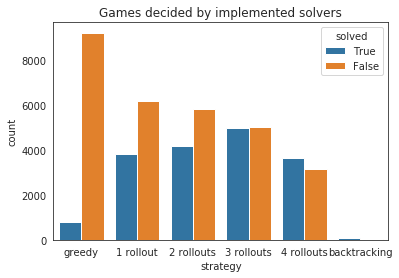

In [14]:
fig, ax = plt.subplots()
fig.patch.set_facecolor('white')
sns.barplot(
    data=outcomes1,
    x='strategy', 
    order=['greedy', '1 rollout', '2 rollouts', '3 rollouts', '4 rollouts', 'backtracking'],
    y='count',
    hue='solved', hue_order=[True,False]
)
plt.title("Games decided by implemented solvers");

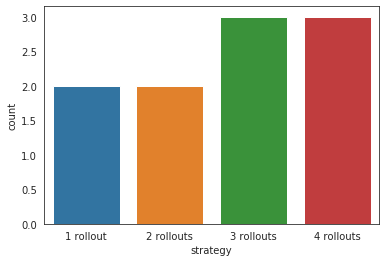

In [15]:
sns.barplot(
    data=outcomes.query('solved==True').query("shootme=='Unknown'"),
    x='strategy',
    y='count'
)

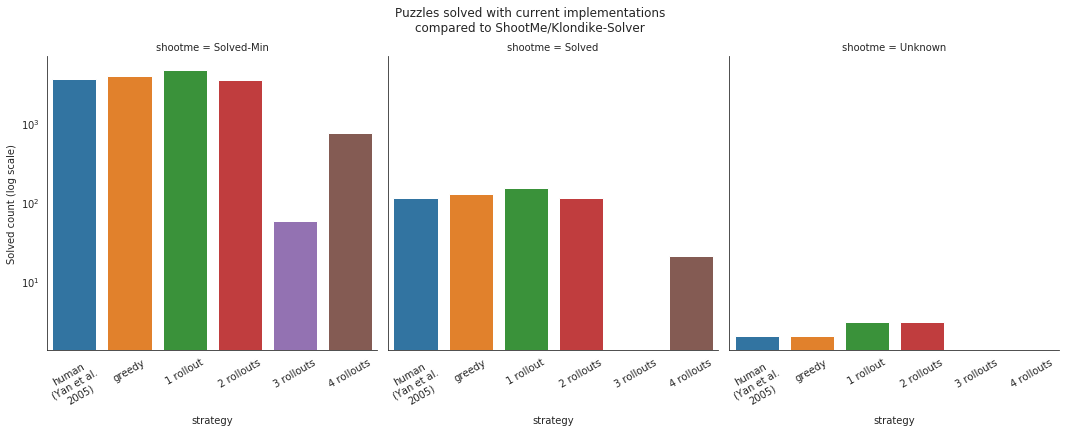

In [16]:
g = sns.catplot(
    kind='bar',
    data=outcomes.query('solved==True'),
    col='shootme', col_order=['Solved-Min', 'Solved', 'Unknown'],
    x='strategy',
    y='count',
#     hue='solved',
    ci=None
)
g.set_axis_labels(y_var="Solved count (log scale)")
g.fig.suptitle("""Puzzles solved with current implementations
compared to ShootMe/Klondike-Solver""", y=1.07)
for ax in g.axes.flat:
    ax.set_yscale('log')
    ax.set_xticklabels(labels, rotation=30)